In [1]:
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import os
import torch

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-21 12:40:15,076	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


Sokoban-v0


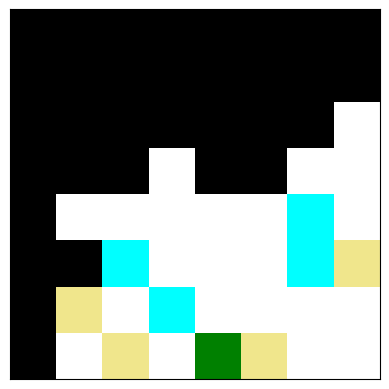

In [3]:
from thinker.actor_net import sample, DRCNet
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False

env = thinker.make(
    "Sokoban-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)

# run the trained drc again
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state)
viz.plot_mini_sokoban(state["real_states"][0])

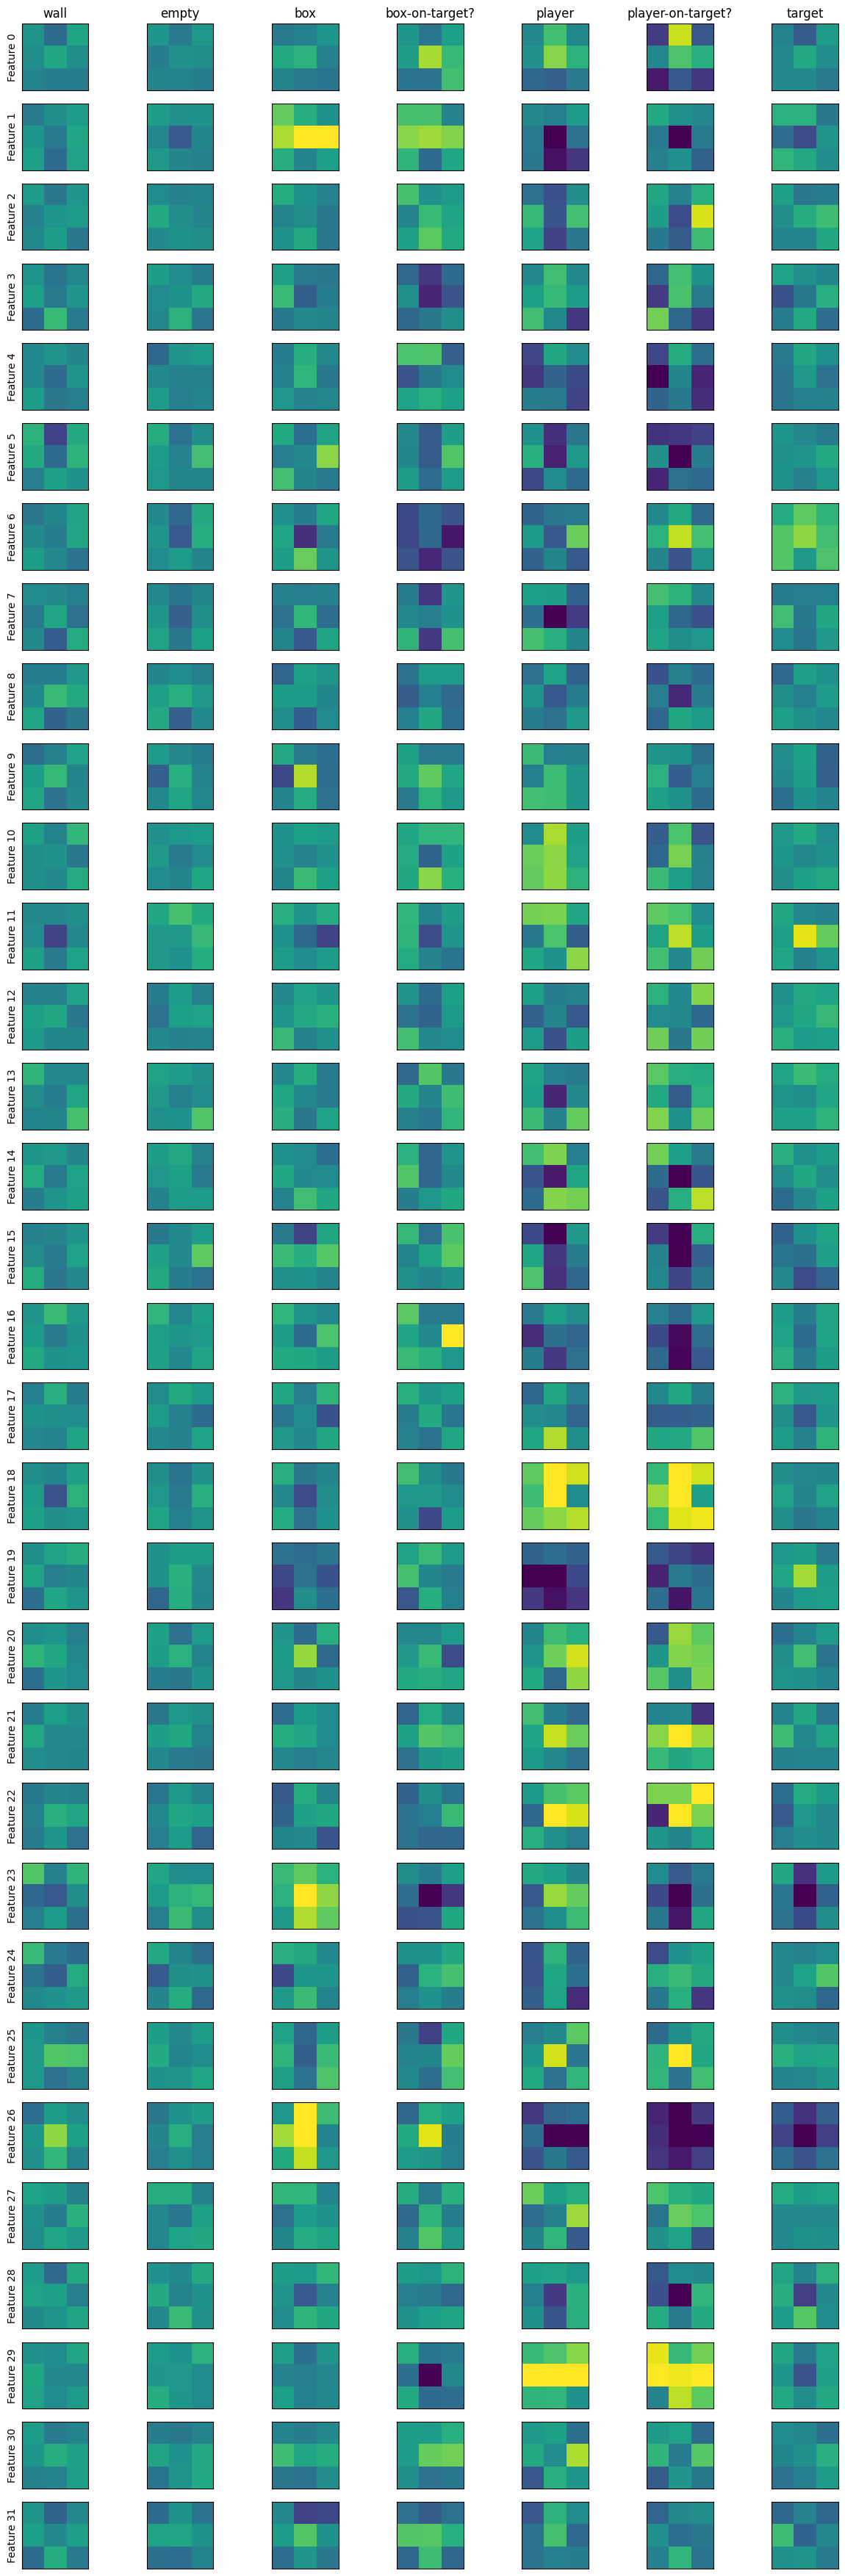

In [52]:
encoder_conv = drc_net.encoder[0].weight.detach() # 32,7,3,3
features = ["wall", "empty", "box", "box-on-target?", "player","player-on-target?", "target"]
fig, axs = plt.subplots(32,7, figsize=(15,45))
for i in range(32):
    for j in range(7):
        weight_img = axs[i][j].imshow(encoder_conv[i][j].flip(dims=(0,1)), vmin=-0.25, vmax=0.25)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        if i == 0:
            axs[i][j].set_title(features[j])
        if j == 0:
            axs[i][j].set_ylabel(f"Feature {i}")

((7, 3, 3), torch.Size([3, 3]))